<a href="https://colab.research.google.com/github/Yujie233/yujie/blob/master/VI_Network_Practical_v0_1_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncertainty Estimation with Probabilistic Discriminative Deep Networks

In this implementation exercise, we understand the notions of aleatoric and epistemic uncertainties and practice modelling such uncertainties for simple deep networks.

## Introduction
In standard discriminative modelling, we try to learn the parameters $\mathbf{\theta}\in \mathbb{R}^p$ of a deep network $f_{\mathbf{\theta}}:\mathcal{X}\rightarrow \mathcal{Y}$ that maps an input $x\in\mathcal{X}$ to its corresponding output $\hat{y}=f_{\mathbf{\theta}}(\mathbf{x})\in\mathcal{Y}$. The parameters $\theta$ are trained on a training set of $n$ samples $\mathcal{D}=\{(\mathbf{x}_i, y_i)\}_{i=1}^{n}$

Uncertainty estimation is concerned with reflecting a *degree of confidence* with a deep network's prediction. That is, instead of directly mapping the input $\mathbf{x}$ to the corresponding prediction $\hat{y}$, it maps it to a distribution over possible outputs $\hat{P}(y|\mathbf{x})$.

In this implementation practical, we first create a toy dataset and then try simple techniques to model two main types of uncertainties: *aleatoric* and *epistemic*.

## Types of Uncertainty 
**Aleatoric uncertainty**, also known as irreducable uncertainty, refers to the inherent uncertainty that are present in the observations $(\mathbf{x},y)$. For instance, the measurements (*e.g.,* length of a tool) can be noisy depending on the precision of the measuring device (*e.g.*, a ruler with one-centimeter markings). This type of uncertainty cannot be remedied by better modelling or additional data, hence the adjective "irreducible". Aleatoric uncertainty can be either *homoscedastic* and *heteroscedastic*. Homoscedastic aleatoric uncertainty does not depend on a sample $\mathbf{x}$ (*e.g.*, the length of a tool can always have a fixed error of up to one centimeter) while a heteroscedastic aleatoric uncertainty can change depending on the sample (*e.g.*, a depth camera might give more error on certain surfaces than others depending on the material of the surface and reflectance and illuminance properties).  

**Epistemic uncertainty**, also known as knowledge uncertainty,  is induced by a model's lack of (enough) knowledge about a certain sample to make a confident prediction on it. As such, epistemic uncertainty can be always considered heteroscedastic *i.e.*, sample-dependent. Knowledge uncertainty is sometimes further divided into separate *model* and *distributional* uncertainties reflecting the uncertainty induced by the inability of modeling and lack of enough data respectively. As such, epistemic uncertainty can be tackled by either improving the modelling or increasing the dataset size.

We will use a few simple methods, described in the lectures, to tackle these uncertainties by using 

i) Maximum Likelihood Estimation (MLE) of aleatoric uncertainty, and 

ii) Variational Inference (VI)-based Bayesian deep networks for epistemic uncertainty.

But let's first create a toy dataset.


In [1]:
# Import the necessary libraries for creating the data (numpy) and plotting it
import numpy as np
import matplotlib.pyplot as plt
import tqdm

%matplotlib inline

np.random.seed(1)

# Toy Regression Dataset Creation 

## Introduction
In this exercise the goal is to familiarize the students with basic concepts of deep probabilistic modelling. As such, we create and use a toy dataset since it will 1) allow us to put more emphasis on the pedagogical aspect of the practical, 2) it will make visualizing the important concepts easier, and 3) reduce the computational load necessary for the analysis.

## Underlying Function
For this first toy dataset, we consider a one-dimensional regression task $\mathcal{X}=\mathbb{R}\rightarrow\mathcal{Y}=\mathbb{R}$. The underlying true function is the periodic even cosine function $y=\text{cos}(x)$. Modelling a periodic function can be generally challenging for a deep network. 

## Basic Clean Training Set
For the basic clean training set $\mathcal{D}$, we create $n=100$ samples with $x\in[-1.3\pi,1.3\pi]$ and store them in the following variables.

```
# X_train       # training points input
# Y_train_true  # training points clean label
```



In [2]:
n = 100
X_train = np.pi * np.linspace(-1.3, 1.3, n).reshape(-1, 1)
Y_train_true = np.cos(X_train)

let's visually inspect our clean training data

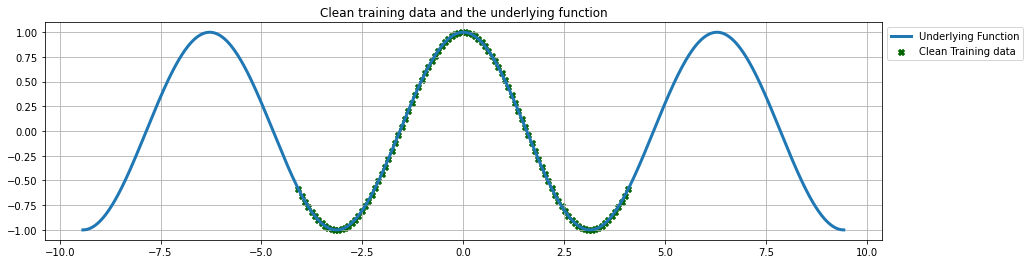

In [3]:
fig = plt.figure(figsize=(15, 4))
ux = np.pi * np.linspace(-3, 3, 1000).reshape(-1, 1)
uy = np.cos(ux)
plt.scatter(X_train, Y_train_true, marker='X', linewidth=1, color='darkgreen', label='Clean Training data')
plt.plot(ux, uy, linewidth=3, label='Underlying Function')
plt.title('Clean training data and the underlying function')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.grid()

so, the training data densely covers the interval [$-1.3\pi, 1.3\pi$).

## Basic Clean Test Set
Now let's create a test set that covers inputs beyond the observed interval during training. For the basic clean test set $\mathcal{D}_{test}$, we create $n_{test}=200$ samples with $x\in[-3\pi,3\pi]$ and store them in the following variables.

```
# X_test       # test points input
# Y_test_true  # test points clean label
```

In [4]:
n_test = 200
X_test = np.pi * np.linspace(-3, 3, n_test).reshape(-1, 1)
Y_test_true = np.cos(X_test)

let's visually inspect our clean test and training data

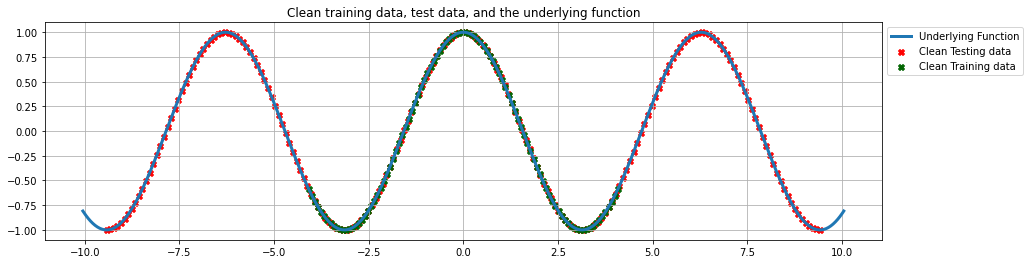

In [5]:
fig = plt.figure(figsize=(15, 4))
ux = np.pi * np.linspace(-3.2, 3.2, 1000).reshape(-1, 1)
uy = np.cos(ux)
plt.scatter(X_test, Y_test_true, marker='X', linewidth=1, color='red', label='Clean Testing data')
plt.scatter(X_train, Y_train_true, marker='X', linewidth=1, color='darkgreen', label='Clean Training data')
plt.plot(ux, uy, linewidth=3, label='Underlying Function')
plt.title('Clean training data, test data, and the underlying function')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.grid()

## Homoscedastic Gaussian Noise on the Training Set
Datasets are commonly noisy due to various reasons, for instance because of the measurement errors. So, a more realistic dataset will contain some noise in the labels. We will first create a dataset containing *homoscedastic* label noise -- a noise independent of the sample. For this, we choose an additive Gaussian noise $\mathcal{N}(0,\sigma^2)$ with variance $\sigma^2=0.01$. We call the dataset with the homoscedastic noise $\mathcal{D}^{homo}$. It contains the same input samples as that of $\mathcal{D}$ but the corresponding labels $y$ are generated with additive gaussian noise and stored in the following variable.

```
# Y_train_homo  # training points label with homoscedastic additive Gaussiannoise
```

In [6]:
gaussian_noise_std = 0.1
gaussian_homoscedastic_noise = np.random.randn(n, 1) * gaussian_noise_std
Y_train_hom = Y_train_true + gaussian_homoscedastic_noise

Now, let us visualize the training data with homoscedastic label noise this time.

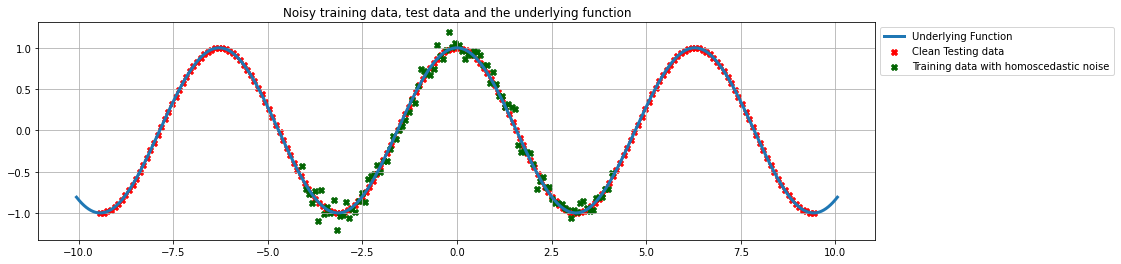

In [7]:
fig = plt.figure(figsize=(15, 4))
ux = np.pi * np.linspace(-3.2, 3.2, 1000).reshape(-1, 1)
uy = np.cos(ux)
plt.scatter(X_test, Y_test_true, marker='X', linewidth=1, color='red', label='Clean Testing data')
plt.scatter(X_train, Y_train_hom, marker='X', linewidth=1, color='darkgreen', label='Training data with homoscedastic noise')
plt.plot(ux, uy, linewidth=3, label='Underlying Function')
plt.title('Noisy training data, test data and the underlying function')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.grid()

## Heteroscedastic Noise on the Training Set
We then create another dataset, but this time, containing *heteroscedastic* label noise -- a noise that is dependent on the sample. It is common for the label noise to be dependent on the magnitude for continuous labels. For this reason, we choose a *multiplicative* Gaussian noise $\mathcal{N}(\mu,\sigma^2)$ with mean $\mu=1$ and variance $\sigma^2=0.01$. We call the dataset with the heteroscedastic noise $\mathcal{D}^{het}$. It contains the same input samples as that of $\mathcal{D}$ but the corresponding labels $y$ are generated with multiplicative gaussian noise and stored in the following variable.

```
# Y_train_het  # training points label with homoscedastic additive Gaussiannoise
```

In [8]:
gaussian_noise_mean = 1
gaussian_noise_std = 0.2
gaussian_heteroscedastic_noise = (np.random.randn(n, 1) * gaussian_noise_std + gaussian_noise_mean - 1) * Y_train_true
Y_train_het = Y_train_true + gaussian_heteroscedastic_noise

Now, let us visualize the training data with heteroscedastic label noise this time.

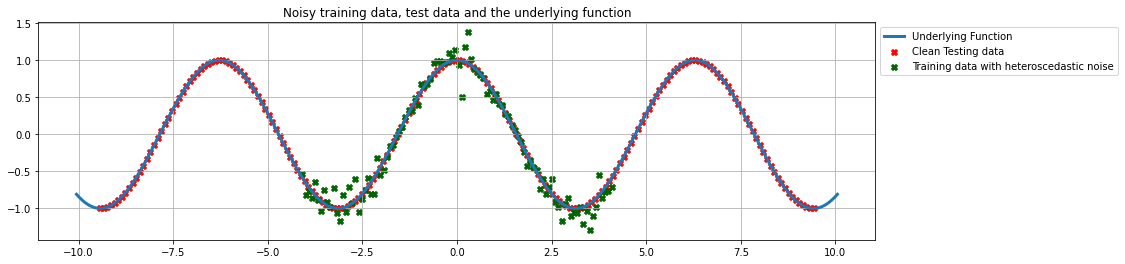

In [9]:
fig = plt.figure(figsize=(15, 4))
ux = np.pi * np.linspace(-3.2, 3.2, 1000).reshape(-1, 1)
uy = np.cos(ux)
plt.scatter(X_test, Y_test_true, marker='X', linewidth=1, color='red', label='Clean Testing data')
plt.scatter(X_train, Y_train_het, marker='X', linewidth=1, color='darkgreen', label='Training data with heteroscedastic noise')
plt.plot(ux, uy, linewidth=3, label='Underlying Function')
plt.title('Noisy training data, test data and the underlying function')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.grid()

# Regularized Risk Minimization

In a regularized risk minimization scheme, we train a model parametrized by $\mathbf{\theta}$, on a training set $\mathcal{D}=\{(x_i,y_i)\}_{i=1}^{n}$, using the following minimization:
\begin{align}
\mathbf{\theta}^*=\text{argmin}_{\mathbf{\theta}} \mathcal{L}(\mathcal{D}) + \Omega(\mathbf{\theta}) = \text{argmin}_{\mathbf{\theta}}\sum_{i=1}^{n}l(f_\theta(x_i), y_i) + \Omega(\mathbf{\theta}), \tag{1}
\end{align}

where $\mathcal{L}$ is the total loss function operating on the who;e training set, $l$ is the sample loss function operating on individual training pairs $(x_i,y_i)$ and $\Omega$ is a regularization cost function.

## Training a Multi-Layer Perceptron (MLP)
Initially, we train a MLP, also known as fully-connected network, parametrized by its weights and biases $\mathbf{\theta}$. We use three hidden layers of size 100,20,100 units and the Rectified Linear Unit (ReLU), $\max(0,h)$, as the activation function. We adopt mean squared error as the loss function and weight decay as the regularization technique. Throughout this practical, we use Jax as the framework to implement our deep networks.

### Jax Deep Learning Framework
Jax uses a standard python (Numpy) implementation for describing a model's operations and enables GPU-optimized and differentible training using XLA and Autograd respectively. A simple tutorial can be found on the project page: https://github.com/google/jax. 

Let us first import the necessary Jax libraries.

In [10]:
import time

import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax import nn
from jax.experimental import optimizers

from functools import partial

""" initialize the random generator """
key = random.PRNGKey(1)

Next, we define the configuration of the fully-connected (FC) network, and then the ReLU activation function.

In [11]:
""" standard network's configurations """
input_dim = X_train.shape[1]
output_dim = Y_train_true.shape[1]
layers_width = [1000, 200, 1000]
num_epochs = 1000
step_size = 1e-2

In [12]:
""" Rectifier Linear Unit (ReLU) activiation function """
ReLU = lambda x:jnp.maximum(0,x)

Now, we define two python functions; one for initializing the parameters of a FC *layer* and another for the feed-forward computation of a FC *layer*.

In [13]:
""" Initialize the parameters of  standard fully-connected layer """
def standard_fc_layer_init(input_dim, output_dim, key, scale=1e-2):
  keys = random.split(key, 2)
  weights = random.normal(keys[0], (output_dim, input_dim)) * scale
  biases  = random.normal(keys[1], (output_dim, 1)) * scale
  return weights, biases

In [14]:
""" Forward pass of a standard fully-connected layer """
def standard_fc_layer_forward(input, weights, biases):
  return ReLU(jnp.dot(weights, input) + biases)

Next, we define two python functions; one for initializing the parameters of a FC *network* and another for the feed-forward computation of a FC *network*.

In [15]:
""" Initialize A standard fully-connected network """
def standard_fc_network_init(input_dim, layers_width, output_dim, key):
  network_feature_dims = [input_dim, *layers_width, output_dim]
  keys = random.split(key, len(network_feature_dims[:-1]))
  params = [standard_fc_layer_init(network_feature_dims[i], network_feature_dims[i+1], keys[i]) for i in range(len(network_feature_dims[:-1]))]
  return params

In [16]:
""" Forward pass of a standard fully-connected network """
def standard_fc_network_forward(input, params, is_classification=False):
  representation = input
  for weights,biases in params[:-1]:
    representation = standard_fc_layer_forward(representation, weights, biases)
  
  representation = jnp.dot(params[-1][0], representation) + params[-1][1]

  if is_classification:
    logits = representation - nn.logsumexp(representation)
    return logits 
  
  return representation

In the following, we define a python function corresponding to the mean squared error (MSE) loss, as 

\begin{align}
\mathcal{L}(\mathcal{D})=\sum_{i=1}^{n}l(f_\theta(x_i),y_i)=\sum_{i=1}^{n}(f_\theta(x_i)-y_i)^2
\end{align}

In [17]:
def loss_mse(params, X, Y):
    """ Compute the multi-class cross-entropy loss """
    preds = standard_fc_network_forward(X, params)
    return jnp.mean(jnp.power(preds[0,:] - Y, 2))

Finally, we implement the code necessary for optimizing the network's parameters using the training data.

In [18]:
""" Compute the gradient for a batch and update the parameters """
@partial(jit, static_argnums=(4,))
def update(params, X, Y, opt_state, loss):
    value, grads = value_and_grad(loss)(params, X, Y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [19]:
""" Implements a learning loop over epochs. """
def run_training_loop(num_epochs, opt_state, X, Y, X_test, Y_test, num_layers, loss):
    # Initialize placeholder for logging
    train_loss, train_mse, test_mse = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial loss after random init
    train_loss.append(loss(params, X.T, Y.T))
    train_mse.append(loss_mse(params[:num_layers], X.T, Y.T))
    test_mse.append(loss_mse(params[:num_layers], X_test.T, Y_test.T))
    print('Starting loss: ', train_loss[-1], ' Starting mse: ', train_mse[-1])

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        params, opt_state, loss_val = update(params, X.T, Y.T, opt_state, loss)

        epoch_time = time.time() - start_time
        test_mse.append(loss_mse(params[:num_layers], X_test.T, Y_test.T))
        train_loss.append(loss(params, X.T, Y.T))
        train_mse.append(loss_mse(params[:num_layers], X.T, Y.T))
        if epoch%200 == 0:
          print("Epoch {} | T: {:0.6f} | Train loss: {:0.3f} | Train mse: {:0.3f} | Test mse: {:0.3f}".format(epoch+1, epoch_time,
                                                                    train_loss[-1], train_mse[-1], test_mse[-1]))

    return params, train_loss, train_mse, test_mse

In [20]:
def visulize_predictions(Y_test_pred, title_text, X_train=[], Y_train=[], sigma_param=-1):
  fig = plt.figure(figsize=(15, 4))
  ux = np.pi * np.linspace(-3, 3, 1000).reshape(-1, 1)
  uy = np.cos(ux)
  plt.plot(ux, uy, linewidth=3, label='Underlying Function')
  plt.plot(X_test, Y_test_pred.T, linewidth=3, color='red', label='Prediction on Testing Points')
  axes = plt.gca()
  axes.set_ylim([-1.5,1.5])
  if not jnp.isscalar(sigma_param) or sigma_param >= 0:
    plt.fill_between(X_test.ravel(), 
                    (Y_test_pred + 2 * sigma_param).ravel(), 
                    (Y_test_pred - 2 * sigma_param).ravel(), 
                    alpha=0.3, label='Epistemic uncertainty')
    plt.scatter(X_train, Y_train, marker='X', linewidth=1, color='darkgreen', label='Clean Training data')
  plt.title(title_text)
  plt.legend(bbox_to_anchor=(1,1), loc="upper left")
  plt.grid()

Finally, let us launch the training for the clean dataset and visualize the learnt function.

In [21]:
# Initialize the network parameters
params = standard_fc_network_init(input_dim, layers_width, output_dim, key)

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

params, train_loss, train_mse, test_mse = run_training_loop(num_epochs, opt_state, X_train, Y_train_true, X_test, Y_test_true, len(layers_width)+1, loss_mse)

Starting loss:  0.55434465  Starting mse:  0.55434465
Epoch 1 | T: 0.956841 | Train loss: 0.421 | Train mse: 0.421 | Test mse: 0.977
Epoch 201 | T: 0.000370 | Train loss: 0.000 | Train mse: 0.000 | Test mse: 0.809
Epoch 401 | T: 0.001148 | Train loss: 0.000 | Train mse: 0.000 | Test mse: 0.818
Epoch 601 | T: 0.001188 | Train loss: 0.000 | Train mse: 0.000 | Test mse: 0.834
Epoch 801 | T: 0.000362 | Train loss: 0.000 | Train mse: 0.000 | Test mse: 0.852


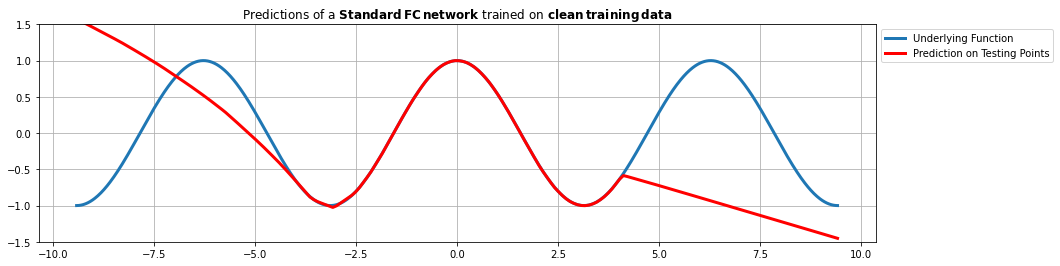

In [22]:
Y_test_pred = standard_fc_network_forward(X_test.T, params)
visulize_predictions(Y_test_pred, r'Predictions of a $\bf{Standard\, FC\, network}$ trained on $\bf{clean\, training\, data}$')

We get a great match in the training range $[-1.3\pi,1.3\pi]$ while the predictions become outside this range which is understandable due to the hardness of generalizing to periodic functions after only observing one period.

Now, let's train and test on the training data with homoscedastic noise

In [23]:
# Initialize the network parameters
params_hom = standard_fc_network_init(input_dim, layers_width, output_dim, key)

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params_hom)

params_hom, train_loss_hom, train_mse_hom, test_mse_hom= run_training_loop(num_epochs, opt_state, X_train, Y_train_hom, X_test, Y_test_true, len(layers_width)+1, loss_mse)

Starting loss:  0.5721841  Starting mse:  0.5721841
Epoch 1 | T: 0.002364 | Train loss: 0.443 | Train mse: 0.443 | Test mse: 0.950
Epoch 201 | T: 0.001954 | Train loss: 0.006 | Train mse: 0.006 | Test mse: 1.805
Epoch 401 | T: 0.000375 | Train loss: 0.005 | Train mse: 0.005 | Test mse: 2.961
Epoch 601 | T: 0.001183 | Train loss: 0.005 | Train mse: 0.005 | Test mse: 3.632
Epoch 801 | T: 0.001230 | Train loss: 0.005 | Train mse: 0.005 | Test mse: 4.761


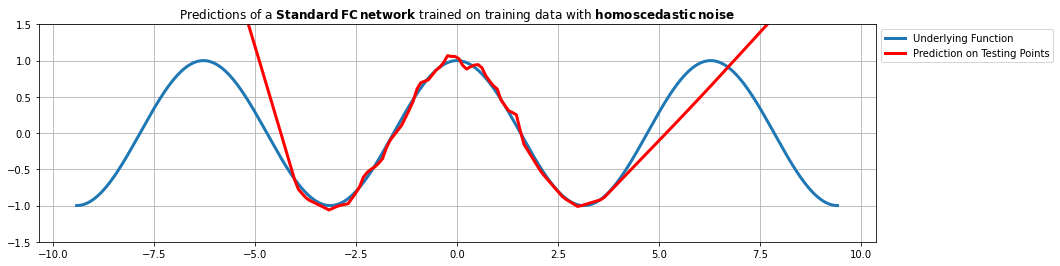

In [24]:
Y_test_pred_hom = standard_fc_network_forward(X_test.T, params_hom)
visulize_predictions(Y_test_pred_hom, r'Predictions of a $\bf{Standard\, FC\, network}$ trained on training data with $\bf{homoscedastic\, noise}$')

We can see that the network overfits to some of the noise present in the training data.

Let us go the dataset exhibiting heteroscedastic label noise next: 

In [25]:
# Initialize the network parameters
params_het = standard_fc_network_init(input_dim, layers_width, output_dim, key)

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params_het)

params_het, train_loss_het, train_mse_het, test_mse_het= run_training_loop(num_epochs, opt_state, X_train, Y_train_het, X_test, Y_test_true, len(layers_width)+1, loss_mse)

Starting loss:  0.60250837  Starting mse:  0.60250837
Epoch 1 | T: 0.000582 | Train loss: 0.454 | Train mse: 0.454 | Test mse: 0.999
Epoch 201 | T: 0.001186 | Train loss: 0.014 | Train mse: 0.014 | Test mse: 0.437
Epoch 401 | T: 0.000370 | Train loss: 0.014 | Train mse: 0.014 | Test mse: 0.376
Epoch 601 | T: 0.000381 | Train loss: 0.013 | Train mse: 0.013 | Test mse: 0.354
Epoch 801 | T: 0.000425 | Train loss: 0.012 | Train mse: 0.012 | Test mse: 0.386


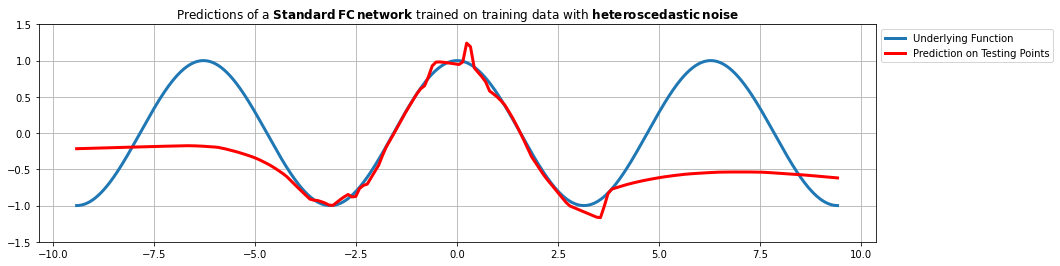

In [26]:
Y_test_pred_het = standard_fc_network_forward(X_test.T, params_het)
visulize_predictions(Y_test_pred_het, r'Predictions of a $\bf{Standard\, FC\, network}$ trained on training data with $\bf{heteroscedastic\, noise}$')

Here we see that the network heavily overfits to most of the heteroscedastic noise present in the training data.

# Training with Assuming a Label Noise Distribution

In the class, we discussed that one way to model aleatoric uncertainty is using maximum likelihood estimation (MLE) in tandem with a model that can output probability distributions. Here, we are going to follow this idea to see how well this approach can predict the aleatoric uncertainty.

## Learning to predict a fixed (homoscedastic) uncertainty
For a maximum likelihood estimation we need to devise a likelihood function. Let's assume a Gaussian likelihood function, parametrized by a deep network to give its mean and variance, given an input. In this first part, we assume the deep network produces a fixed variance independent of the input sample while the mean is dependent on the input sample. That is, our likelihood function

\begin{align}
P(y|\mathbf{x};\mathbf{\theta}) = \mathcal{N}(\mu=f_{\mathbf{\theta}}(\mathbf{x}),\sigma^2=f'_\theta).
\end{align}

First, we consider an additional parameter for the fixed variance and initialize the rest of the network parameters

In [ ]:
# assume one scalar for the fixed standard dev of the likelihood's Gaussian
sigma_param = jnp.array(jnp.log(0.2))

# Initialize the network parameters that will produce the mean of the likelihood's Gaussian
params_homo_model_clean_data = standard_fc_network_init(input_dim, layers_width, output_dim, key)

# add the likelihood's Gaussian's standard dev to the list of parameters
params_homo_model_clean_data.append(sigma_param)

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params_homo_model_clean_data)

# Modelling Aleatoric Uncertainty: Learning to predict a fixed (homoscedastic) uncertainty

In the class, we discussed that one way to model aleatoric uncertainty is using maximum likelihood estimation (MLE) in tandem with a model that can output probability distributions. Here, we are going to follow this idea to see how well this approach can predict the aleatoric uncertainty.

For a maximum likelihood estimation we need to devise a likelihood function. Let's assume a Gaussian likelihood function, parametrized by a deep network to give its mean and variance, given an input. In this part, we assume the deep network produces a fixed variance independent of the input sample while the mean is dependent on the input sample. That is, our likelihood function

\begin{align}
P(y|\mathbf{x};\mathbf{\theta}) = \mathcal{N}(\mu=f_{\mathbf{\theta}}(\mathbf{x}),\sigma^2=f'_\theta).
\end{align}

Then, we would like to find $\theta$ that maximizes the likelihood of our observed data:

\begin{align}
\mathbf{\theta}^*=\text{argmax}_\mathbf{\theta}\prod_{i=1}^{n}P(y_i|\mathbf{x}_i;\mathbf{\theta}).
\end{align}

Taking the log and plugging in the Normal distributions we get

\begin{align}
\mathbf{\theta}^*=\text{argmax}_\mathbf{\theta}\sum_{i=1}^{n}\log \mathcal{N}(\mu=f_{\mathbf{\theta}}(\mathbf{x}_i),\sigma^2=f'_\theta)|_{y_i}= \text{argmin}_\mathbf{\theta}[\sum\limits_{i=1}^{n}{(\log \sqrt{2\pi {{{{f}'}}_{\theta }}}+\frac{{{({{y}_{i}}-{{f}_{\theta }}({{\mathbf{x}}_{i}}))}^{2}}}{2{{{{f}'}}_{\theta }}})}]
\end{align}

Your job is now to fill in the missing part above and implement the corresponding loss function. Note that the last term is an *argmin*.


In [33]:
def loss_mle_homoscedastic(params, X, Y):
    """
    ==============================
    TODO: Implementation required.
    ==============================
    1. Assume params[-1] contains the natural logarithm of the standard_deviation
    2. Return the total loss calculated as you derived above.
    """
    preds = standard_fc_network_forward(X, params[:-1])
    return (jnp.mean(jnp.power(preds[0,:] - Y, 2)))/(2)+jnp.log(jnp.sqrt(2*jnp.pi))
    #return jnp.sum(jnp.power(preds[0,:] - Y, 2)/2+jnp.log(jnp.sqrt(2*jnp.pi)))
    

In [35]:
params_homo_model_clean_data, train_loss_homo_model_clean_data, train_mse_homo_model_clean_data, test_mse_homo_model_clean_data = run_training_loop(num_epochs, opt_state, X_train, Y_train_true, X_test, Y_test_true, len(layers_width)+1, loss_mle_homoscedastic)

sigma_param = jnp.exp(np.asarray(params_homo_model_clean_data[-1]))
print('The final trained homoscedastic standard deviation for clean data is: ', sigma_param)

Y_test_pred_homo_model_clean_data = standard_fc_network_forward(X_test.T, params_homo_model_clean_data[:-1])

visulize_predictions(Y_test_pred_homo_model_clean_data,  r'Predictions of a $\bf{Homoscedastic\, FC\, network}$ trained on training data with $\bf{clean\, labels}$', X_train, Y_train_true, sigma_param)


Starting loss:  1.1959987  Starting mse:  0.55434465
Epoch 1 | T: 0.000452 | Train loss: 1.141 | Train mse: 0.557 | Test mse: 0.503
Epoch 201 | T: 0.001195 | Train loss: 0.919 | Train mse: 0.569 | Test mse: 0.507
Epoch 401 | T: 0.000420 | Train loss: 0.919 | Train mse: 0.569 | Test mse: 0.507
Epoch 601 | T: 0.001159 | Train loss: 0.919 | Train mse: 0.568 | Test mse: 0.507
Epoch 801 | T: 0.000401 | Train loss: 0.919 | Train mse: 0.568 | Test mse: 0.507


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: ignored

Now, let us try it on the noisy data with fixed (homoscedastic) additive noise.

Starting loss:  1.2050306  Starting mse:  0.5721841
Epoch 1 | T: 1.034450 | Train loss: 1.140 | Train mse: 0.443 | Test mse: 0.944
Epoch 201 | T: 0.001354 | Train loss: 0.922 | Train mse: 0.005 | Test mse: 0.779
Epoch 401 | T: 0.001251 | Train loss: 0.921 | Train mse: 0.005 | Test mse: 0.997
Epoch 601 | T: 0.007575 | Train loss: 0.921 | Train mse: 0.005 | Test mse: 1.077
Epoch 801 | T: 0.001292 | Train loss: 0.921 | Train mse: 0.005 | Test mse: 0.882
The final trained homoscedastic standard deviation for data with fixed additive Gaussian noise is:  0.19999999


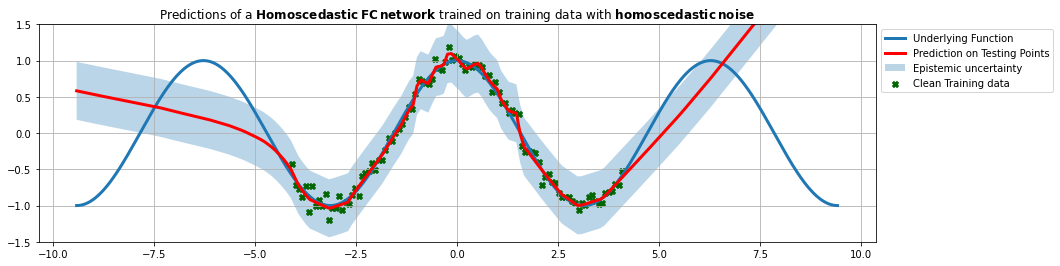

In [36]:
# assume one scalar for the fixed standard dev of the likelihood's Gaussian
sigma_param = jnp.array(jnp.log(0.2))

# Initialize the network parameters that will produce the mean of the likelihood's Gaussian
params_homo_model_homo_data = standard_fc_network_init(input_dim, layers_width, output_dim, key)

# add the likelihood's Gaussian's standard dev to the list of parameters
params_homo_model_homo_data.append(sigma_param)

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params_homo_model_homo_data)

params_homo_model_homo_data, train_loss_homo_model_homo_data, train_mse_homo_model_homo_data, test_mse_homo_model_homo_data = run_training_loop(num_epochs, opt_state, X_train, Y_train_hom, X_test, Y_test_true, len(layers_width)+1, loss_mle_homoscedastic)

sigma_param = jnp.exp(params_homo_model_homo_data[-1])
print('The final trained homoscedastic standard deviation for data with fixed additive Gaussian noise is: ', sigma_param)

Y_test_pred_homo_model_homo_data = standard_fc_network_forward(X_test.T, params_homo_model_homo_data[:-1])

visulize_predictions(Y_test_pred_homo_model_homo_data, r'Predictions of a $\bf{Homoscedastic\, FC\, network}$ trained on training data with $\bf{homoscedastic\, noise}$', X_train, Y_train_hom, sigma_param)


Now, let us try it on the data with variable (heteroscedastic) label noise.

Starting loss:  1.2201927  Starting mse:  0.60250837
Epoch 1 | T: 0.000578 | Train loss: 1.146 | Train mse: 0.454 | Test mse: 0.993
Epoch 201 | T: 0.000428 | Train loss: 0.925 | Train mse: 0.013 | Test mse: 0.649
Epoch 401 | T: 0.001779 | Train loss: 0.924 | Train mse: 0.010 | Test mse: 0.603
Epoch 601 | T: 0.000478 | Train loss: 0.923 | Train mse: 0.008 | Test mse: 0.609
Epoch 801 | T: 0.000435 | Train loss: 0.923 | Train mse: 0.008 | Test mse: 0.590
The final trained homoscedastic standard deviation for data with variable (heteroscedastic) noise is:  0.19999999


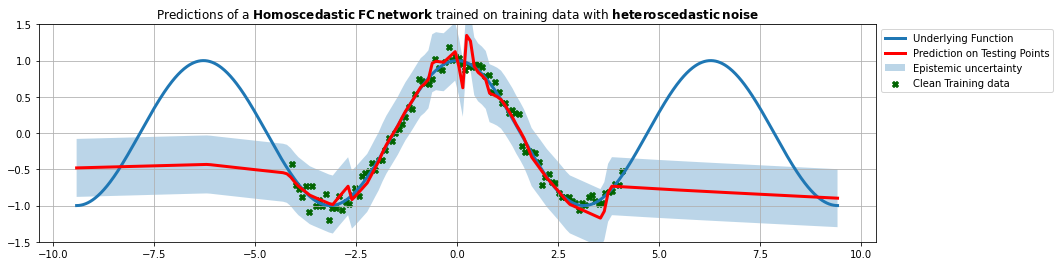

In [37]:
# assume one scalar for the fixed standard dev of the likelihood's Gaussian
sigma_param = jnp.array(jnp.log(0.2))

# Initialize the network parameters that will produce the mean of the likelihood's Gaussian
params_homo_model_het_data = standard_fc_network_init(input_dim, layers_width, output_dim, key)

# add the likelihood's Gaussian's standard dev to the list of parameters
params_homo_model_het_data.append(sigma_param)

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params_homo_model_het_data)

params_homo_model_het_data, train_loss_homo_model_het_data, train_mse_homo_model_het_data, test_mse_homo_model_het_data = run_training_loop(num_epochs, opt_state, X_train, Y_train_het, X_test, Y_test_true, len(layers_width)+1, loss_mle_homoscedastic)

sigma_param = jnp.exp(params_homo_model_het_data[-1])
print('The final trained homoscedastic standard deviation for data with variable (heteroscedastic) noise is: ', sigma_param)

Y_test_pred_homo_model_het_data = standard_fc_network_forward(X_test.T, params_homo_model_het_data[:-1])

visulize_predictions(Y_test_pred_homo_model_het_data, r'Predictions of a $\bf{Homoscedastic\, FC\, network}$ trained on training data with $\bf{heteroscedastic\, noise}$', X_train, Y_train_hom, sigma_param)


**Note.** A working implementation of the loss function should learn to put lower aleatoric uncertainty on the clean training data than the noisy ones.

# Variational Inference for Deep Regression Networks
In this practical we are interested in epistemic uncertainty estimation with deep networks based on the following paper.

[1] Blundell et al., "Weight Uncertainty in Neural Networks", ICML 2015

---


In order to model epistemic uncertainty, we can use Bayesian modelling to obtain a posterior distribution on model parameters:

\begin{align}
P(\mathbf{\theta}|\mathcal{D})= \frac{P(\mathcal{D}|\mathbf{\theta})P(\mathbf{\theta})}{P(\mathcal{D})}
\end{align}

Using this posterior distribution, we can transfer the uncertainty in model parameters to uncertainty in predictive distribution, for a new test sample $\mathbf{x}$:

\begin{align}
  P(y|\mathbf{x},\mathcal{D})=\int P(y|\mathbf{x},\mathbf{\theta})P(\mathbf{\theta}|\mathcal{D})d\theta.
\end{align}

However, obtaining $P(\mathbf{\theta}|\mathcal{D})$ can be problematic due to the interactability of calculating $P(\mathcal{D})$. Thus there are several techniques developed to approximate the posterior distribution $P(\mathbf{\theta}|\mathcal{D})$. One of these techniques is called Variational Inference (VI). In VI, we seek to identify another, simpler, distribution $Q_\omega(\theta)$, parametrized by $\omega$, that approximates $P(\theta|\mathcal{D})$. In VI we can maximize the variational lower bound (ELBO) as follows (details provided in the course lectures and the VAE practical):

\begin{align}
\omega^*=\text{argmin}_{\omega} -\mathbb{E}_{Q_\omega(\theta)}[logP(\mathcal{D}|\theta)]+\text{D}_{\text{KL}}(Q_\omega(\theta)||P(\theta))
\end{align}

Assuming i.i.d. dataset $\mathcal{D}$ we will have:

\begin{align}
\omega^*=\text{argmin}_{\omega} -\mathbb{E}_{Q_\omega(\theta)}[\sum^{n}_{i=1}logP(y_i|\mathbf{x}_i,\theta)]+\text{D}_{\text{KL}}(Q_\omega(\theta)||P(\theta))
\end{align}

Using monte-carlo estimation of the expecation with $S$ samples we get:

\begin{align}
\omega^*=\text{argmin}_{\omega} -\frac{1}{S}\sum_{s=1}^{S}\sum^{n}_{i=1}logP(y_i|\mathbf{x}_i,\theta_s)+\text{D}_{\text{KL}}(Q_\omega(\theta)||P(\theta)), \tag{2}
\end{align}

where, $\{\theta_s\}_{s=1}^{S}\sim Q_\omega(\theta)$.

Let us consider the following distributions:

*   $P(\theta)=\mathcal{N}(0, 10^{-4}\mathbf{I})$
*   $Q_{\omega=(\mu,\sigma^2)}(\theta)=\mathcal{N}(\mathbf{\mu}, \text{diag}(\mathbf{\sigma}^2))$
*   $P(y|\mathbf{x},\theta)=\mathcal{N}(f_{\theta}(\mathbf{x}), \epsilon)$

where $\mathbf{\mu}\in\mathbb{R}^p$ and $\mathbf{\sigma}^2\in\mathbb{R}^p$ denote respectively the learnable mean vector and the diagnoal of the learnable diagnoal covariance matrix for the approximate distribution $Q$. Furthermore, $f_{\theta}$ is the deep network's function for a fixed network parameters $\theta$ (*e.g.*, sampled from $Q$). $f_{\theta}(\mathbf{x})$ denotes the output of the network for an input $\mathbf{x}$ which is in turn used as the mean likelihood $P(y|\mathbf{x},\theta)=\mathcal{N}(f_{\theta}(\mathbf{x}), \epsilon)$. Note that, for simplicity, we have devised a likelihood function  with a fixed variance $\epsilon$. This means that the model assumes a known fixed aleatoric uncertainty (*e.g.*, $\epsilon=1$). Of course, one can easily extend the model to also learn aleatoric uncertainty as in the last part of the exercise that you have done!

Following [1], to avoid numerical issues when learning the variance vector $\mathbf{\sigma}^2$, in the implementation we will learn a vector ${\rho}$  instead and obtain the variance using the softplus operation as:

\begin{align}
  \sigma=\text{log}(1+\exp(\rho)) 
\end{align}

Now, your job is to plug in the distributions above into the objective in equation 2 assuming a single-sample monte-carlo estimate ($S=1$). Note that the KL divergence of two Gaussians have a closed-from solution and the natural logarithm of a Gaussian gives away two simple terms and a constant. Fill in the following objective equation with your derived terms:


    ==============================
    TODO: Complete equations.
    ==============================

\begin{align}
\omega^*=\text{argmin}_{\omega=\{\mathbf{\mu},\mathbf{\sigma}^2\}}\sum\limits_{i=1}^{n}{(\log \sqrt{2\pi \varepsilon }+\frac{{{({{y}_{i}}-{{f}_{\theta }}({{\mathbf{x}}_{i}}))}^{2}}}{2\varepsilon })+}\frac{1}{\sqrt{2\pi }\text{log}(1+\exp (\rho ))}\exp \{-\frac{{{(\theta -\mu )}^{2}}}{2{{[\text{log}(1+\exp (\rho ))]}^{2}}}\}\{\log \sqrt{2\times {{10}^{-4}}\varepsilon }+\frac{{{\theta }^{2}}}{2\times {{10}^{-4}}}-\log [\sqrt{2\pi }\text{log}(1+\exp (\rho ))]-\frac{{{(\theta -\mu )}^{2}}}{2{{[\text{log}(1+\exp (\rho ))]}^{2}}}\}
\end{align}

Furthermore, the forward pass of this model requires a sampling from the approximate distribution. From what we discussed in the class, we know backpropagating through a stochastic node is problematic. One simple remedy, among others [2], to this problem is as we saw called *reparametrization trick* [1]. There, for a Gaussian distribution $\mathcal{N}(\mathbf{\mu}, \text{diag}(\mathbf{\sigma}^2))$, one can sample from the (non-learnable) standard Gaussian $\mathbf{z}\sim\mathcal{N}(\mathbf{0}, \mathbf{I})$ and then transfer its sample $\mathbf{z}$ into a sample of the original distribution by

\begin{align}
  \theta_s= \mathbf{\sigma}\otimes\mathbf{z} + \mathbf{\mu}
\end{align}

where $\otimes$ denotes an elementwise (Hadamard) product.

In the following you will need to implement the objective function that you derived above and the reparametrization trick.

---
[1] Blundell et al., "Weight Uncertainty in Neural Networks", ICML 2015

[2] Bengio, et al., "Estimating or Propagating Gradients", 2013

In [38]:
""" VI network's configurations """
input_dim = X_train.shape[1]
output_dim = Y_train_true.shape[1]
layers_width = [100, 20, 100]
kl_prior_mean = 0
kl_prior_sigma = 1e-2
kl_weight = 1e-4

In [39]:
""" Initialize the parameters of a VI-based fully-connected layer """
def vi_fc_layer_init(input_dim, output_dim, key, scale=1e-2):
  keys = random.split(key, 2)
  weights_mean = random.normal(keys[0], (output_dim, input_dim)) * scale
  weights_rho = -2*jnp.ones((output_dim, input_dim))
  biases_mean  = random.normal(keys[1], (output_dim, 1)) * scale
  biases_rho = -2*jnp.ones((output_dim, 1))
  return weights_mean, weights_rho, biases_mean, biases_rho

In [40]:
""" Forward pass of a VI-based fully-connected layer """
def vi_fc_layer_forward(input, weights_mean, weights_rho, biases_mean, biases_rho, key):
  """
    ==============================
    TODO: Implementation required.
    ==============================
    Implement the reparametrization trick:
    1. Sample from a standard Gaussian distribution using random.normal
    2. Transform the sample into a sample of the desired Gaussian distribution
  """
  weights_sigma = nn.softplus(weights_rho)
  biases_sigma = nn.softplus(biases_rho)
  keys = random.split(key, 2)
  weights_eps = random.normal(keys[0], shape=(output_dim, input_dim))
  weights = jnp.multiply(weights_sigma,weights_eps)+weights_mean
  biases_eps = random.normal(keys[1], shape=(output_dim, 1))
  biases = jnp.multiply(biases_sigma,biases_eps)+biases_mean
  return jnp.dot(weights, input) + biases
  #weights_eps = ...
  #weights = ...
  #biases_eps = ...
  #biases = ...
  #return ...

In [41]:
""" Initialize a VI-based fully-connected network """
def vi_fc_network_init(input_dim, layers_width, output_dim, key):
  network_feature_dims = [input_dim, *layers_width, output_dim]
  keys = random.split(key, len(network_feature_dims[:-1]))
  params = [vi_fc_layer_init(network_feature_dims[i], network_feature_dims[i+1], keys[i]) for i in range(len(network_feature_dims[:-1]))]
  return params

In [42]:
""" Forward pass of a VI-based fully-connected network """
def vi_fc_network_forward(input, params, key, is_classification=False):

  representation = input
  keys = random.split(key, len(params))

  for (weights_mean, weights_rho, biases_mean, biases_rho), key in zip(params[:-1], keys[:-1]):
    representation = ReLU(vi_fc_layer_forward(representation, weights_mean, weights_rho, biases_mean, biases_rho, key))
  representation = vi_fc_layer_forward(representation, params[-1][0], params[-1][1], params[-1][2], params[-1][3], keys[-1]) 
  
  return representation

In [43]:
params = vi_fc_network_init(input_dim, layers_width, output_dim, key)

In [44]:
"""
  calculates the KL-divergence of two diagnoal gaussians. For convenience, p_mu and p_sigma can be scalars.
"""

def kl_divergence_two_diagnoal_gaussians(q_mu, q_sigma, p_mu, p_sigma):        

    q_mu = q_mu.flatten()
    q_sigma = q_sigma.flatten()

    N = q_mu.shape[0]

    p_sigma *= p_sigma
    q_sigma *= q_sigma

    if jnp.isscalar(p_mu):
      p_mu = p_mu * jnp.ones_like(q_mu) 
      p_sigma = p_sigma * jnp.ones_like(q_mu)
    else:
      p_mu = p_mu.flatten()
      p_sigma = p_sigma.flatten()

    p_mu = p_mu.reshape(N)
    q_mu = q_mu.reshape(N)
    p_sigma = p_sigma.reshape(N)
    q_sigma = q_sigma.reshape(N)

    ip_sigma = 1/p_sigma
    diff = p_mu - q_mu

    tr_term   = jnp.sum(ip_sigma * q_sigma)
    det_term  = jnp.sum(jnp.log(p_sigma/q_sigma))
    quad_term = diff.T @ jnp.diag(1/p_sigma) @ diff 

    return .5 * (tr_term + det_term + quad_term - N) 

In [46]:
def vi_loss(params, X, Y, prior_mu, prior_sigma, kl_weight, key, is_classification=False):
    """
    ==============================
    TODO: Implementation required.
    ==============================
    Implement the VI loss function you derived in the instructions
    1. Either use the provided implementation of the KL divergence of two Gaussians in kl_divergence_two_diagnoal_gaussians or implement one
    2. Complete the loss function calculation below
    3. For better learning use kl_weight as a coefficient to downweigh the KL term (prior), i.e., - expected_log_likelihood_term + kl_wieght*kl_prior_term  
    """
    preds = vi_fc_network_forward(X, params, key)
    total_loss = (jnp.sum(jnp.power(preds[0,:] - Y, 2)))/(2)+jnp.log(jnp.sqrt(2*jnp.pi))
    # total_loss = ...
    for weights_mean, weights_rho, biases_mean, biases_rho in params:
      total_loss += kl_weight*kl_divergence_two_diagnoal_gaussians(weights_mean+biases_mean, jnp.sqrt(nn.softplus(weights_rho)*nn.softplus(weights_rho)+nn.softplus(biases_rho)*nn.softplus(biases_rho)), prior_mu, prior_sigma)
      # total_loss += ... 
    return total_loss 

In [47]:
""" Compute the gradient for a batch and update the parameters """
@jit
def update(params, X, Y, opt_state, key):
    value, grads = value_and_grad(vi_loss)(params, X, Y, kl_prior_mean, kl_prior_sigma, kl_weight, key)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

# Defining an optimizer in Jax
step_size = 1e-2
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

num_epochs = 1000

In [48]:
""" Implements a learning loop over epochs. """

def run_training_loop(num_epochs, opt_state, X, Y, X_test, Y_test):
    # Initialize placeholder for logging
    train_loss, test_loss = [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    keys = random.split(key)

    # Get initial accuracy after random init
    train_loss.append(vi_loss(params, X.T, Y.T, kl_prior_mean, kl_prior_sigma, kl_weight, keys[0]))
    test_loss.append(vi_loss(params, X_test.T, Y_test.T, kl_prior_mean, kl_prior_sigma, kl_weight, keys[1]))

    keys = random.split(key, num_epochs*2)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        params, opt_state, loss_val = update(params, X.T, Y.T, opt_state, keys[epoch*2])
        train_loss.append(loss_val)

        epoch_time = time.time() - start_time
        test_loss.append(vi_loss(params, X_test.T, Y_test.T, kl_prior_mean, kl_prior_sigma, kl_weight, keys[epoch*2+1]))
        if epoch%100 == 0:
          print("Epoch {} | T: {:0.6f} | Train loss: {:0.3f} | Test loss: {:0.3f}".format(epoch+1, epoch_time,
                                                                    train_loss[-1], test_loss[-1]))

    return params, train_loss, test_loss

In [49]:
def visualize_VI(params, X_train, Y_train, plot_title, num_trials = 10):
  
  Y_test_pred_list = []

  keys = random.split(key, num_trials)

  for i in tqdm.tqdm(range(num_trials)):
      Y_test_pred = vi_fc_network_forward(X_test.T, params, keys[i])
      Y_test_pred_list.append(Y_test_pred)
      
  Y_test_preds = np.concatenate(Y_test_pred_list, axis=0)
  print(Y_test_preds.shape)

  Y_test_pred_mean = np.mean(Y_test_preds, axis=0)
  Y_test_pred_sigma = np.std(Y_test_preds, axis=0)
  visulize_predictions(Y_test_pred_mean, plot_title, X_train, Y_train, Y_test_pred_sigma)


Epoch 1 | T: 10.040198 | Train loss: 781.521 | Test loss: 244546.969
Epoch 101 | T: 0.002244 | Train loss: 116.310 | Test loss: 147.714
Epoch 201 | T: 0.007533 | Train loss: 109.342 | Test loss: 140.250
Epoch 301 | T: 0.002312 | Train loss: 79.427 | Test loss: 175.844
Epoch 401 | T: 0.002310 | Train loss: 104.574 | Test loss: 136.309
Epoch 501 | T: 0.009422 | Train loss: 106.562 | Test loss: 148.404
Epoch 601 | T: 0.002244 | Train loss: 145.177 | Test loss: 172.020
Epoch 701 | T: 0.002616 | Train loss: 103.592 | Test loss: 127.201
Epoch 801 | T: 0.002294 | Train loss: 85.837 | Test loss: 107.664
Epoch 901 | T: 0.002211 | Train loss: 73.126 | Test loss: 524.584


100%|██████████| 10/10 [00:00<00:00, 22.53it/s]


(10, 200)


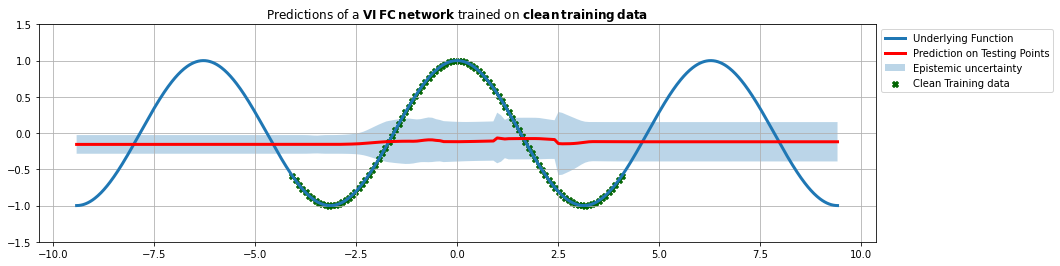

In [50]:
params, train_loss, test_loss= run_training_loop(num_epochs, opt_state, X_train, Y_train_true, X_test, Y_test_true)
visualize_VI(params, X_train, Y_train_true, r'Predictions of a $\bf{VI\, FC\, network}$ trained on $\bf{clean\, training\, data}$', num_trials = 10)

Epoch 1 | T: 0.002696 | Train loss: 784.366 | Test loss: 244546.969
Epoch 101 | T: 0.002408 | Train loss: 117.235 | Test loss: 147.513
Epoch 201 | T: 0.002527 | Train loss: 110.198 | Test loss: 140.002
Epoch 301 | T: 0.009645 | Train loss: 80.250 | Test loss: 175.128
Epoch 401 | T: 0.002401 | Train loss: 105.357 | Test loss: 135.902
Epoch 501 | T: 0.002322 | Train loss: 107.270 | Test loss: 147.894
Epoch 601 | T: 0.002439 | Train loss: 146.851 | Test loss: 172.371
Epoch 701 | T: 0.002599 | Train loss: 104.956 | Test loss: 127.226
Epoch 801 | T: 0.002451 | Train loss: 87.472 | Test loss: 107.798
Epoch 901 | T: 0.002697 | Train loss: 74.679 | Test loss: 548.899


100%|██████████| 10/10 [00:00<00:00, 22.94it/s]


(10, 200)


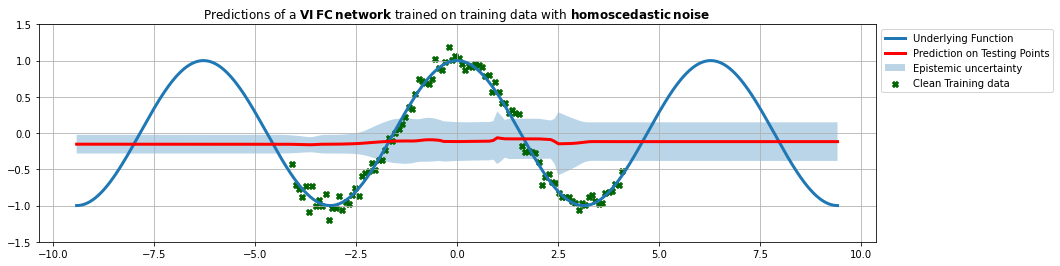

In [51]:
params, train_loss, test_loss= run_training_loop(num_epochs, opt_state, X_train, Y_train_hom, X_test, Y_test_true)
visualize_VI(params, X_train, Y_train_hom, r'Predictions of a $\bf{VI\, FC\, network}$ trained on training data with $\bf{homoscedastic\, noise}$', num_trials = 10)

**Note.** A proper implementation would show growing uncertainty as we move away from the training region.